In [102]:
import sys

base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)

In [113]:
from math import sqrt

import keras
import numpy as np
import pandas as pd
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from src.scaler import Scaler
from src.dataframe import read_data_from_csv, read_data, show_error_metrics, windowing, split_data
from src.filler import interpolate_filler, fill_df

In [104]:
step_back=5

In [105]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('units',
                                       min_value=32,
                                       max_value=512,
                                       step=32),
                          return_sequences=True,
                          activation=hp.Choice('activation', ['relu', 'sigmoid']),
                          input_shape=(step_back, 3)))
    model.add(layers.Dropout(rate=hp.Float(
        'dropout',
        min_value=0.0,
        max_value=0.5,
        default=0.25,
        step=0.05,
    )))
    model.add(layers.LSTM(units=hp.Int('units_2',
                                       min_value=32,
                                       max_value=512,
                                       step=32),
                          activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh'])))
    model.add(layers.Dense(1, activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh'])))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])))
    return model

def model_search(
        name,
        train_x,
        train_y,
        max_trials=20,
        executions_per_trial=3,
        epochs=10,
        validation_split=0.3
):
    tuner = RandomSearch(
        build_model,
        seed=13418236482,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory='models',
        project_name=name)

    tuner.search_space_summary(True)

    tuner.search(train_x, train_y,
                 epochs=epochs,
                 validation_split=validation_split)

    return tuner.get_best_hyperparameters()[0]

In [106]:
df = read_data_from_csv(f'{base_path}/data/daily_barbacena.csv')

In [107]:
df = fill_df(df, interpolate_filler)

In [108]:
scaler = Scaler(df, (0,1))
df_scaled = scaler.get_dataframe_scaled()
print(df, df_scaled)

            RADIATION       TEMP  HUMIDITY_h
2003-03-21    19996.0  20.329167   81.375000
2003-03-22    10907.0  19.037500   88.250000
2003-03-23    10874.0  18.029167   89.250000
2003-03-24    13185.0  18.520833   87.958333
2003-03-25    20082.0  19.262500   80.958333
...               ...        ...         ...
2022-12-27    14196.5  18.629167   88.958333
2022-12-28    10448.3  19.625000   88.500000
2022-12-29     8247.8  19.362500   92.208333
2022-12-30     8331.0  18.958333   93.458333
2022-12-31    12611.2  18.854167   90.083333

[7226 rows x 3 columns]             RADIATION      TEMP  HUMIDITY_h
2003-03-21   0.230131  0.606321    0.773381
2003-03-22   0.117728  0.541440    0.858171
2003-03-23   0.117320  0.490791    0.870504
2003-03-24   0.145900  0.515488    0.854573
2003-03-25   0.231194  0.552742    0.768243
...               ...       ...         ...
2022-12-27   0.158409  0.520929    0.866906
2022-12-28   0.112055  0.570950    0.861254
2022-12-29   0.084842  0.557765    0.90

In [109]:
X, Y = windowing(df_scaled, predict_column='RADIATION', step_back=step_back, step_front=1)
train_x, train_y, test_x, test_y = split_data(X, Y, length=len(df_scaled), ratio=0.9)

## LSTM

In [110]:
#hp = model_search('interpolate_lstm_5_1_barbacena', train_x, train_y, 20, 3, 10, 0.3)
#hp.values

Trial 8 Complete [00h 01m 56s]
val_loss: 0.004041260729233424

Best val_loss So Far: 0.004041260729233424
Total elapsed time: 00h 03m 06s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
352               |512               |units
0.35              |0.35              |dropout
320               |288               |units_2
sigmoid           |sigmoid           |activation
0.01              |0.001             |learning_rate

Epoch 1/10
143/143 [==============================] - 4s 22ms/step - loss: 0.0466 - val_loss: 0.0419
Epoch 2/10
143/143 [==============================] - 3s 22ms/step - loss: 0.0461 - val_loss: 0.0419
Epoch 3/10
143/143 [==============================] - 3s 21ms/step - loss: 0.0461 - val_loss: 0.0419
Epoch 4/10
143/143 [==============================] - 3s 21ms/step - loss: 0.0461 - val_loss: 0.0419
Epoch 5/10
143/143 [==============================] - 3s 21ms/step - loss: 0.0461 - val_loss: 0.0419
Epoch 6/10
143/143 [===================

KeyboardInterrupt: 

In [ ]:
# model = build_model(hp)

# # fit network
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
# history = model.fit(train_x,
#                     train_y,
#                     epochs=200,
#                     batch_size=72,
#                     validation_data=(test_x, test_y),
#                     validation_split=0.3,
#                     verbose=2,
#                     callbacks=[es],
#                     workers=4,
#                     use_multiprocessing=True)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='validation')
# pyplot.legend()
# pyplot.show()

In [ ]:
# predict = model.predict(test_x)

# real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
# predict = scaler.scales['RADIATION'].inverse_transform(predict)

In [ ]:
# range_plot = 100

# pyplot.plot(real[0:range_plot], color='blue', label='real')
# pyplot.plot(predict[0:range_plot], color='red', label='incompleto')

# show_error_metrics(real, predict)

# pyplot.show()

## Manual Model

In [ ]:
print(test_x.shape, test_y.shape)

(717, 5, 3) (717,)


In [115]:
from keras.models import Sequential
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [124]:
model2 = load_model('models-keras/lstm-interpolation-5-1')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 350)               495600    
                                                                 
 dense_13 (Dense)            (None, 1)                 351       
                                                                 
Total params: 495951 (1.89 MB)
Trainable params: 495951 (1.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model Summary None
Epoch 1/5000
92/92 [==============================] - 2s 16ms/step - loss: 0.0067 - val_loss: 0.0041
Epoch 2/5000
92/92 [==============================] - 1s 13ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 3/5000
92/92 [==============================] - 1s 13ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 4/5000
92/92 [==============================] - 1s 13ms/step - loss: 0.0041 - val_los

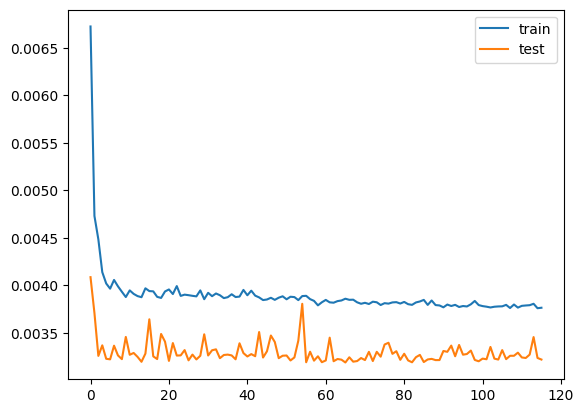

In [134]:
model2 = Sequential([
    LSTM(units=350, input_shape=(step_back, 3), return_sequences=True),
    Dropout(rate=0.25),
    LSTM(units=350),
    Dense(1, activation='sigmoid')
])

model2 = Sequential([
    InputLayer(input_shape=(step_back, 3)),
    LSTM(units=350),
    Dense(1, activation='relu')
])

model2.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam())

print('Model Summary', model2.summary())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)
#cp = ModelCheckpoint('models-keras/lstm-interpolation-5-1', save_best_only=True)

history = model2.fit(train_x,
                     train_y,
                     epochs=5000,
                     batch_size=64,
                     validation_split=0.1,
                     verbose=1,
                     callbacks=[es],
                     #workers=4,
                     use_multiprocessing=True)

#model2 = load_model('models-keras/lstm-interpolation-5-1')

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [135]:
model2.evaluate(test_x, test_y, verbose=1)

 1/23 [>.............................] - ETA: 0s - loss: 0.0037

23/23 [==============================] - 0s 5ms/step - loss: 0.0032


0.0031559227500110865

In [137]:
predict = model2.predict(test_x, batch_size=72)


real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
predict = scaler.scales['RADIATION'].inverse_transform(predict)

10/10 [==============================] - 0s 6ms/step


Test R2: 0.505
Test MSE: 20635004.528
Test RMSE: 4542.577
Test MAE: 3535.868
Test MAPE: 0.331


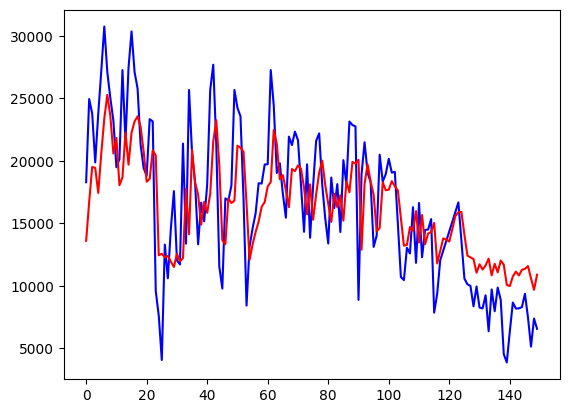

In [138]:
range_plot = 150

pyplot.plot(real[0:range_plot], color='blue', label='real')
pyplot.plot(predict[0:range_plot], color='red', label='incompleto')

show_error_metrics(real, predict)

pyplot.show()